In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time, timedelta
from sklearn.model_selection import train_test_split

In [4]:
def plot_learning_curve(evals_result):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(np.arange(len(evals_result['training']['binary_error'])),
            evals_result['training']['binary_error'], label='Training')
    ax.plot(np.arange(len(evals_result['valid_1']['binary_error'])),
            evals_result['valid_1']['binary_error'], label='Validation')
    ax.set_title('Learning Curve')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Binary Error')
    ax.legend()
    plt.show()

def plot_feature_importance(importances, feature_names):
    importance = pd.DataFrame({"Feature": feature_names,
                               "Importance": importances})
    importance.sort_values(by="Importance", ascending=False, inplace=True)
    plt.figure(figsize=(15, 30))
    sns.barplot(x="Importance", y="Feature", data=importance)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

In [5]:
df = pd.read_csv('../csv/BTCUSDT_1m_20210801_20221231.csv')
display(df)

# Assume 80% of the data is used for training and 20% for testing
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

,date,open,high,low,close,volume
0,1627743660000,41340.58,41347.05,41340.58,41347.05,0.000546
1,1627743720000,41347.05,41347.05,41320.71,41320.71,0.001308
2,1627743780000,41320.71,41320.71,41309.40,41309.40,0.001086
3,1627743840000,41309.40,41314.08,41309.40,41314.08,0.000481
4,1627743900000,41314.08,41327.25,41314.08,41327.25,0.002747
...,...,...,...,...,...,...
740795,1672413540000,16508.20,16512.86,16498.28,16508.61,15.606035
740796,1672413600000,16508.61,16523.98,16504.91,16504.91,18.356253
740797,1672413660000,16504.91,16513.00,16502.58,16510.18,7.890198
740798,1672413720000,16510.18,16517.09,16499.36,16517.09,9.953238


In [6]:
def summarize_trade_results(trade_results):
    num_trades = len(trade_results['profits'])
    num_wins = sum(1 for x in trade_results['profits'] if x > 0)
    num_losses = num_trades - num_wins

    average_win = sum(x for x in trade_results['profits'] if x > 0) / num_wins if num_wins > 0 else 0
    average_loss = sum(x for x in trade_results['profits'] if x < 0) / num_losses if num_losses > 0 else 0

    profit_factor = -average_win / average_loss if average_loss != 0 else 0

    long_win_rate = sum(1 for x in trade_results['long_profits'] if x > 0) / len(trade_results['long_profits']) if trade_results['long_profits'] else 0
    short_win_rate = sum(1 for x in trade_results['short_profits'] if x > 0) / len(trade_results['short_profits']) if trade_results['short_profits'] else 0

    # Print the statistics
    print("Total trade Num", len(trade_results['profits']))
    print("Profit Factor:", profit_factor)
    print("Long Trade Num:", len(trade_results['long_profits']))
    print("Long Win Rate:", long_win_rate)
    print("Short Trade Num:", len(trade_results['short_profits']))
    print("Short Win Rate:", short_win_rate)

    # Create cumulative return series
    cumulative_returns = np.cumsum(trade_results['profits'])
    cumulative_long_returns = np.cumsum(trade_results['long_profits'])
    cumulative_short_returns = np.cumsum(trade_results['short_profits'])

    # Plot the results
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_returns, label='Total Returns')
    plt.title("Cumulative Total Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_long_returns, label='Long Returns', color='blue')
    plt.plot(cumulative_short_returns, label='Short Returns', color='red')
    plt.title("Cumulative Long and Short Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
class OptimalFRule:
    def __init__(self, initial_lot, wins_losses):
        self.lot = initial_lot
        self.wins_losses = wins_losses
        self.optimize_f()

    def optimize_f(self):
        best_f = 0
        best_return = 0
        for f in range(0, 101):
            f = f / 100
            capital = 1
            for wl in self.wins_losses:
                capital *= (1 + f * wl)
            if capital > best_return:
                best_return = capital
                best_f = f
        self.optimal_f = best_f / 4  # オプティマルfの4分の1を使用

    def update_lot(self, profit):
        self.lot *= (1 + self.optimal_f * profit)

    def apply_lot(self, profit):
        return profit * self.lot

Total trade Num 593055
Profit Factor: 693.458701681513
Long Trade Num: 415
Long Win Rate: 0.6433734939759036
Short Trade Num: 597
Short Win Rate: 0.6716917922948074


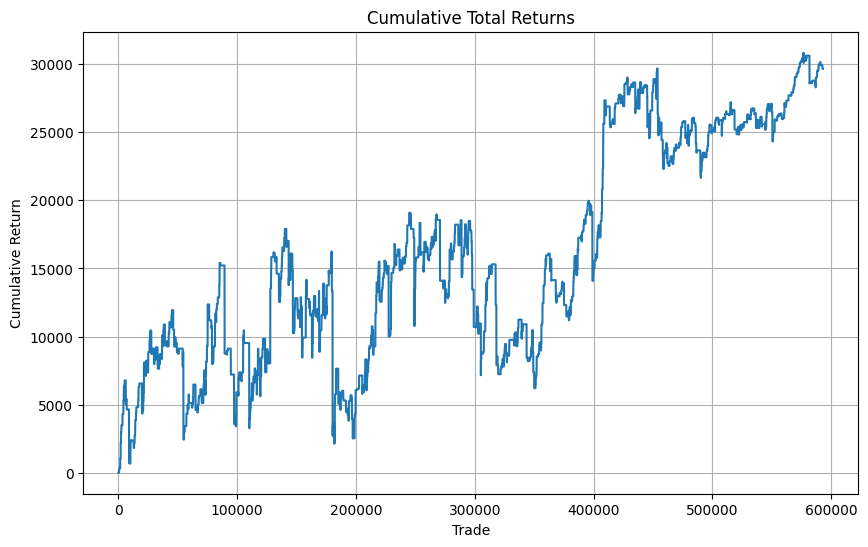

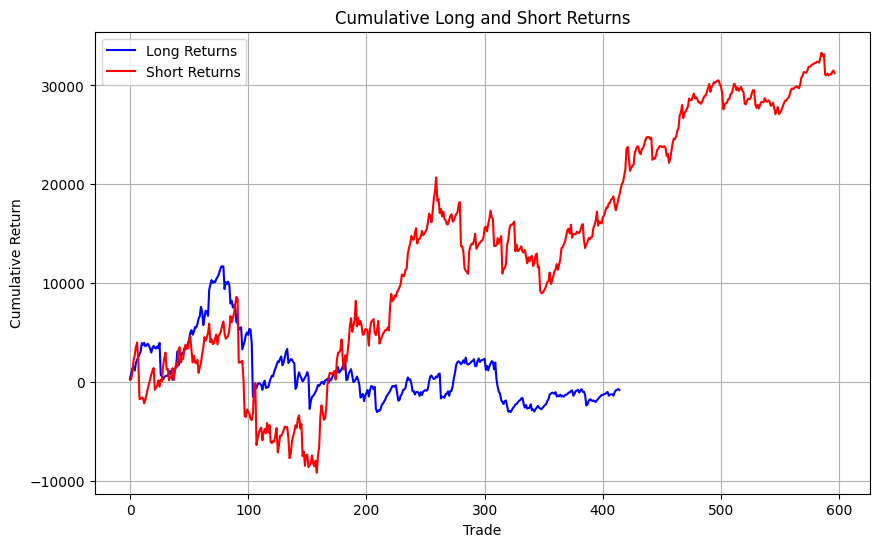

In [8]:
# Backtest

# Indicator
from ta.momentum import RSIIndicator

# Initialize trade_results
trade_results = {
    'profits': [],
    'long_profits': [],
    'short_profits': [],
}

# Initialize portfolio state
portfolio = {
    'position': None,  # "long" or "short"
    'entry_price': None,
    'entry_point': 0
}

# バックテストに使用するデータフレームを指定
df = train_df

# Calculate moving averages
df['short_ma'] = df['close'].rolling(window=50).mean()
df['long_ma'] = df['close'].rolling(window=200).mean()

# Determine the trend
df.loc[df['short_ma'] > df['long_ma'], 'trend'] = 1
df.loc[df['short_ma'] < df['long_ma'], 'trend'] = 0

rsi_indicator = RSIIndicator(close=df['close'])
df['RSI'] =  rsi_indicator.rsi()

# Loop through the data
for i in range(0, len(df)):
    profit = 0

    data_row = df.iloc[i]

    rsi = data_row['RSI']
    trend = df.iloc[i]['trend']

    if portfolio['position'] is not None:
        if portfolio['position'] == 'long' and rsi > 70:
            profit = data_row['close'] - portfolio['entry_price']
            trade_results['profits'].append(profit)
            trade_results['long_profits'].append(profit)
            portfolio = {
                'position': None,
                'entry_price': None,
                'entry_point': 0
            }

        if portfolio['position'] == 'short' and rsi < 20:
            profit = portfolio['entry_price'] - data_row['close']
            trade_results['profits'].append(profit)
            trade_results['short_profits'].append(profit)
            portfolio = {
                'position': None,
                'entry_price': None,
                'entry_point': 0
            }

        else:
            trade_results['profits'].append(profit)
    
    elif rsi < 20 and trend == 0:
        trade_results['profits'].append(profit)
        portfolio = {
            'position': 'long',
            'entry_price': data_row['close'],
            'entry_point': i
        }

    elif rsi > 70 and trend == 1:
        trade_results['profits'].append(profit)
        portfolio = {
            'position': 'short',
            'entry_price': data_row['close'],
            'entry_point': i
        }

    else:
        trade_results['profits'].append(profit)

summarize_trade_results(trade_results)